<a href="https://colab.research.google.com/github/chanwoo522/Hackathon/blob/main/%5BGPU%5DAug_Color_Mil_Aircraft_Image_Resnet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 라이브러리 임포트

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import re

In [35]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Oct 14 08:44:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    32W / 250W |  16017MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [37]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## 구글 드라이브 마운트

In [38]:
# load image files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 작업 폴더 설정

In [39]:
## directory 설정
cur_dir = os.path.abspath('/content/drive/Shareddrives/aircraft')
image_dir = os.path.join(cur_dir, 'mil_raw_image')

In [40]:
# Experiment directory setting

train_dir = os.path.join(cur_dir, 'train_aug')
valid_dir = os.path.join(cur_dir, 'valid_color')
test_dir = os.path.join(cur_dir, 'test_color')

classes = os.listdir(image_dir)

In [41]:
valid_data = datasets.ImageFolder(root = valid_dir, 
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in valid_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(valid_data)
stds /= len(valid_data)

pretrained_means = means
pretrained_stds = stds
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.3432, 0.3693, 0.3895])
Calculated stds: tensor([0.2961, 0.3103, 0.3303])


## 데이터 정규화 및 로드

In [42]:
# Hyperparameter
## Dataload
BATCH_SIZE = 16   # 16, 64, 128
img_size = 256
pretrained_means = pretrained_means
pretrained_stds = pretrained_stds

train_data length : 5600
valid_data length : 700
test_data length : 140
train RGB Channel size, W, H : torch.Size([3, 256, 256])
valid RGB Channel size, W, H : torch.Size([3, 256, 256])
test RGB Channel size, W, H : torch.Size([3, 256, 256])
train_iterator length : 350
valid_iterator length : 44
test_iterator length : 9


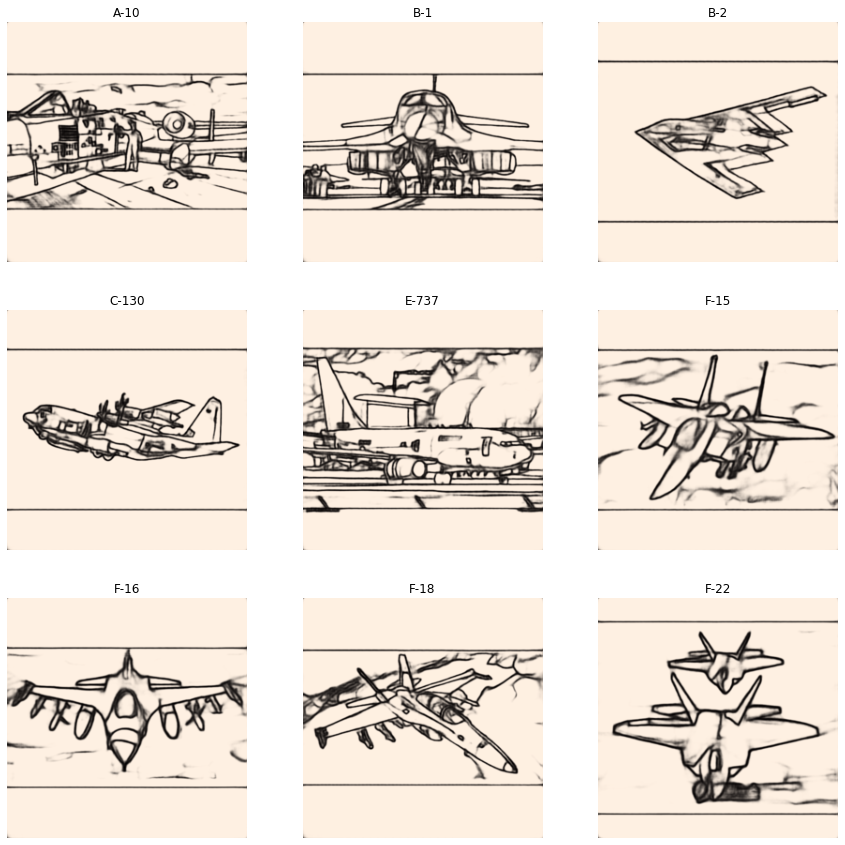

In [43]:
# Data load and transform
transform = transforms.Compose([
                                transforms.Resize((img_size, img_size)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = pretrained_means,
                                                     std = pretrained_stds)#,
                                #transforms.Grayscale(num_output_channels=1)
])

train_data = datasets.ImageFolder(root=train_dir, transform=transform)
valid_data = datasets.ImageFolder(root=valid_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

train_iterator = data.DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle=True)
valid_iterator = data.DataLoader(dataset = valid_data, batch_size = BATCH_SIZE, shuffle=True)
test_iterator = data.DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle=True)

# Dataset check
print('train_data length :', len(train_data))
print('valid_data length :', len(valid_data))
print('test_data length :', len(test_data))
print('train RGB Channel size, W, H :', train_data[0][0].size())
print('valid RGB Channel size, W, H :',valid_data[0][0].size())
print('test RGB Channel size, W, H :',test_data[0][0].size())
print('train_iterator length :', len(train_iterator))
print('valid_iterator length :', len(valid_iterator))
print('test_iterator length :', len(test_iterator))

def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (15, 15))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image = images[i]
        if normalize:
            image = normalize_image(image)
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

N_IMAGES = 14
images, labels = zip(*[(image, label) for image, label in [train_data[i*400] for i in range(N_IMAGES)]])
classes = test_data.classes
plot_images(images, labels, classes)

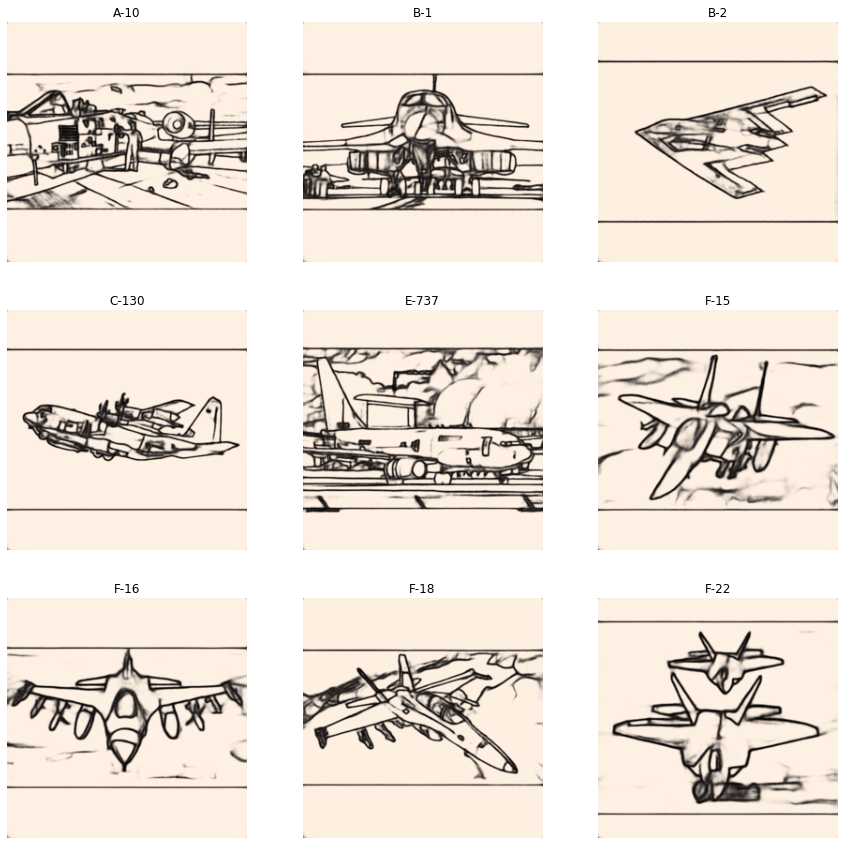

In [44]:
def format_label(label):
    label = label.split('.')[-1]
    label = label.replace('_', ' ')
    label = label.title()
    label = label.replace(' ', '')
    return label
test_data.classes = [format_label(c) for c in test_data.classes]
classes = test_data.classes
plot_images(images, labels, classes)

In [45]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [46]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

resnet18_config = ResNetConfig(block = BasicBlock,n_blocks = [2,2,2,2], channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock, n_blocks = [3,4,6,3], channels = [64, 128, 256, 512])

class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

resnet50_config = ResNetConfig(block = Bottleneck, n_blocks = [3, 4, 6, 3], channels = [64, 128, 256, 512])
resnet101_config = ResNetConfig(block = Bottleneck, n_blocks = [3, 4, 23, 3], channels = [64, 128, 256, 512])
resnet152_config = ResNetConfig(block = Bottleneck, n_blocks = [3, 8, 36, 3], channels = [64, 128, 256, 512])

class CIFARResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, layers, channels = config
        self.in_channels = channels[0]
            
        assert len(layers) == len(channels) == 3
        assert all([i == j*2 for i, j in zip(channels[1:], channels[:-1])])
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        
        self.layer1 = self.get_resnet_layer(block, layers[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, layers[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, layers[2], channels[2], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(channels, channels))

        self.in_channels = channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [47]:
resnet50_config = ResNetConfig(block = Bottleneck, n_blocks = [3, 4, 6, 3], channels = [64, 128, 256, 512])
resnet101_config = ResNetConfig(block = Bottleneck, n_blocks = [3, 4, 23, 3], channels = [64, 128, 256, 512])
resnet152_config = ResNetConfig(block = Bottleneck, n_blocks = [3, 8, 36, 3], channels = [64, 128, 256, 512])

class CIFARResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, layers, channels = config
        self.in_channels = channels[0]
            
        assert len(layers) == len(channels) == 3
        assert all([i == j*2 for i, j in zip(channels[1:], channels[:-1])])
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        
        self.layer1 = self.get_resnet_layer(block, layers[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, layers[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, layers[2], channels[2], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(channels, channels))

        self.in_channels = channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

class Identity(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
        
    def forward(self, x):
        return self.f(x)
        

class CIFARBasicBlock(nn.Module):
        
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            identity_fn = lambda x : F.pad(x[:, :, ::2, ::2], 
                                           [0, 0, 0, 0, in_channels // 2, in_channels // 2])
            downsample = Identity(identity_fn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                                
        x += i
        x = self.relu(x)
        
        return x

cifar_resnet20_config = ResNetConfig(block = CIFARBasicBlock, n_blocks = [3, 3, 3], channels = [16, 32, 64])
cifar_resnet32_config = ResNetConfig(block = CIFARBasicBlock, n_blocks = [5, 5, 5], channels = [16, 32, 64])
cifar_resnet44_config = ResNetConfig(block = CIFARBasicBlock, n_blocks = [7, 7, 7], channels = [16, 32, 64])
cifar_resnet56_config = ResNetConfig(block = CIFARBasicBlock, n_blocks = [9, 9, 9], channels = [16, 32, 64])
cifar_resnet110_config = ResNetConfig(block = CIFARBasicBlock, n_blocks = [18, 18, 18], channels = [16, 32, 64])
cifar_resnet1202_config = ResNetConfig(block = CIFARBasicBlock, n_blocks = [20, 20, 20], channels = [16, 32, 64])

In [48]:
pretrained_model = models.resnet50(pretrained = True)
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc
model = ResNet(resnet50_config, OUTPUT_DIM)
model.load_state_dict(pretrained_model.state_dict())
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,536,718 trainable parameters


In [49]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

Stopping early, the loss has diverged


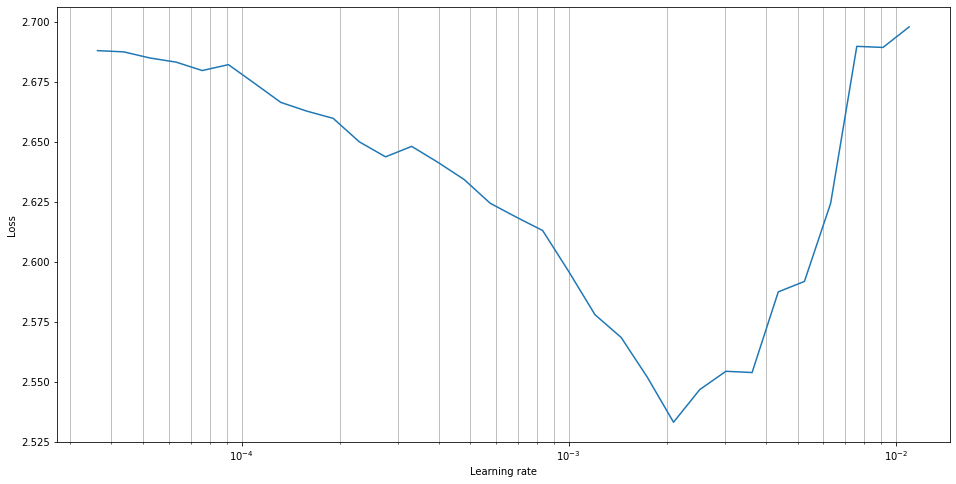

In [50]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()
    
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

In [51]:
FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]

optimizer = optim.Adam(params, lr = FOUND_LR)

EPOCHS = 100
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr = MAX_LRS, total_steps = TOTAL_STEPS)

def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    return epoch_loss, epoch_acc_1, epoch_acc_5

def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [52]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 1m 49s
	Train Loss: 2.012 | Train Acc @1:  40.29% | Train Acc @5:  78.80%
	Valid Loss: 1.327 | Valid Acc @1:  61.55% | Valid Acc @5:  89.73%
Epoch: 02 | Epoch Time: 1m 49s
	Train Loss: 0.845 | Train Acc @1:  76.50% | Train Acc @5:  97.30%
	Valid Loss: 0.798 | Valid Acc @1:  75.33% | Valid Acc @5:  94.55%
Epoch: 03 | Epoch Time: 1m 49s
	Train Loss: 0.363 | Train Acc @1:  90.59% | Train Acc @5:  99.45%
	Valid Loss: 0.636 | Valid Acc @1:  80.26% | Valid Acc @5:  96.59%
Epoch: 04 | Epoch Time: 1m 49s
	Train Loss: 0.149 | Train Acc @1:  96.95% | Train Acc @5:  99.93%
	Valid Loss: 0.632 | Valid Acc @1:  82.20% | Valid Acc @5:  97.02%
Epoch: 05 | Epoch Time: 1m 49s
	Train Loss: 0.100 | Train Acc @1:  97.70% | Train Acc @5:  99.98%
	Valid Loss: 0.599 | Valid Acc @1:  82.15% | Valid Acc @5:  96.73%
Epoch: 06 | Epoch Time: 1m 48s
	Train Loss: 0.102 | Train Acc @1:  96.93% | Train Acc @5:  99.96%
	Valid Loss: 0.779 | Valid Acc @1:  78.84% | Valid Acc @5:  95.83%
Epoch: 07 

In [53]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

Test Loss: 0.913 | Test Acc @1:  76.85% | Test Acc @5:  92.36%


In [54]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (50, 50));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)

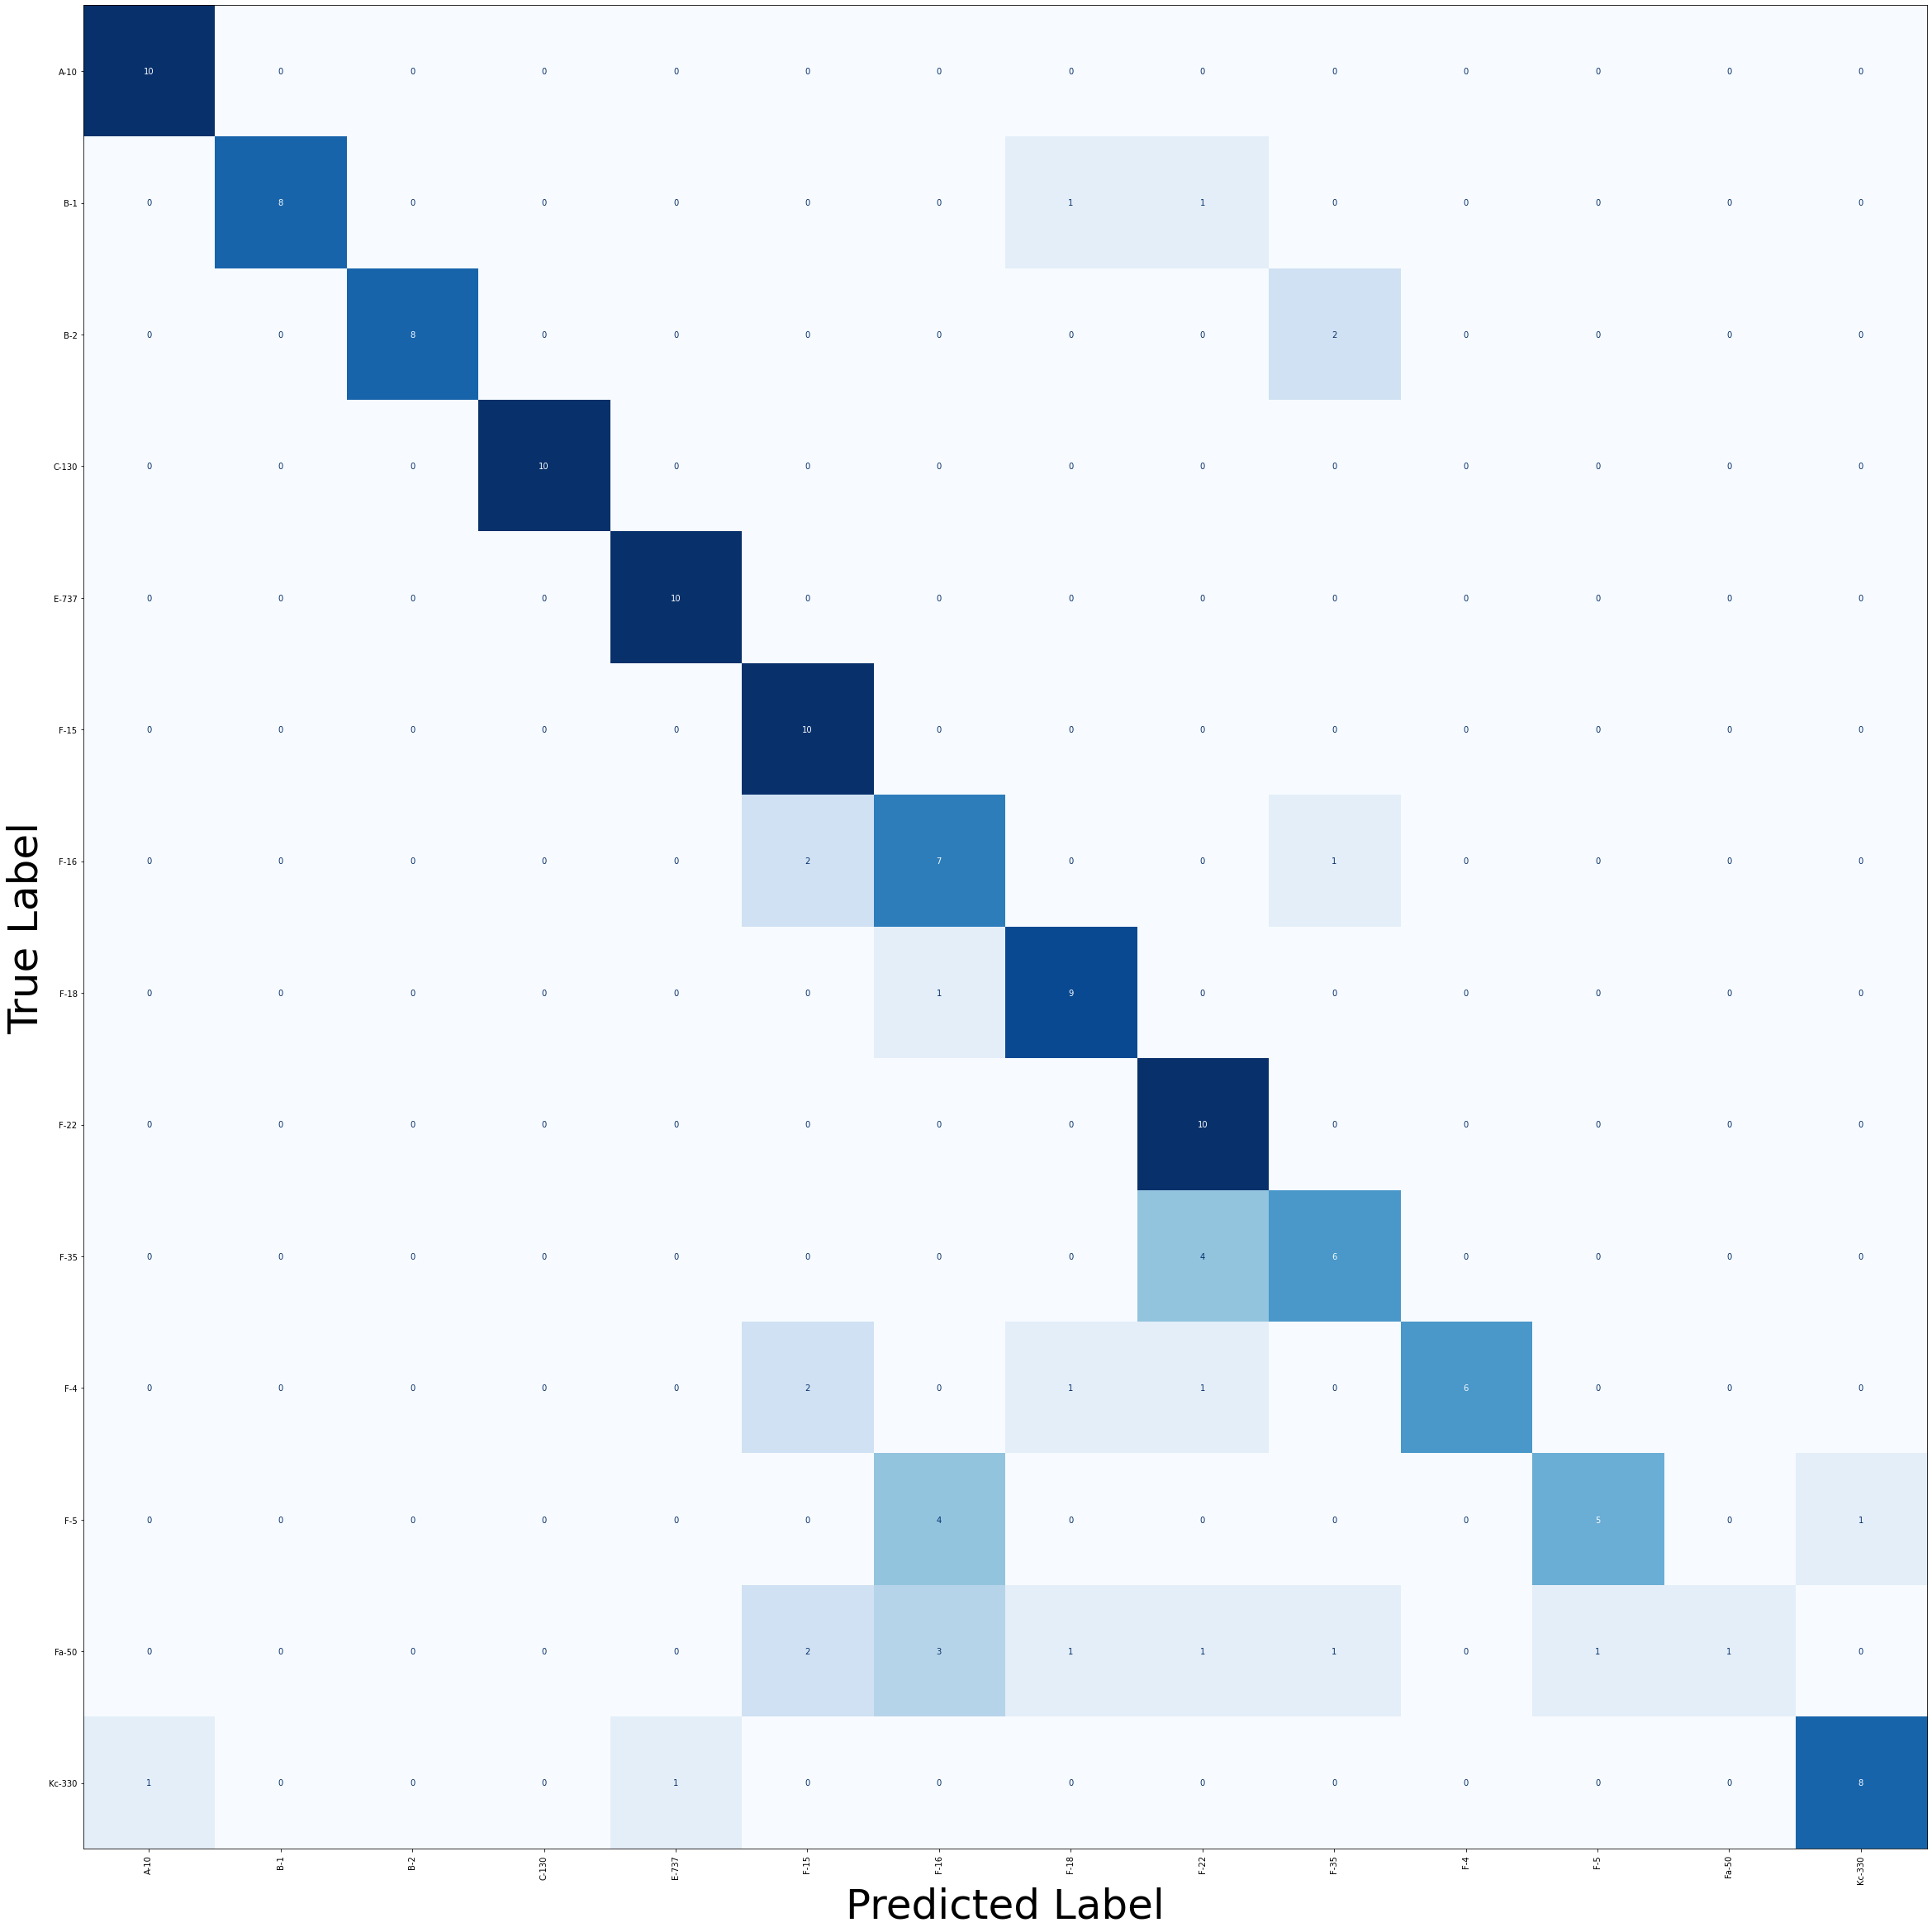

In [55]:
plot_confusion_matrix(labels, pred_labels, classes)

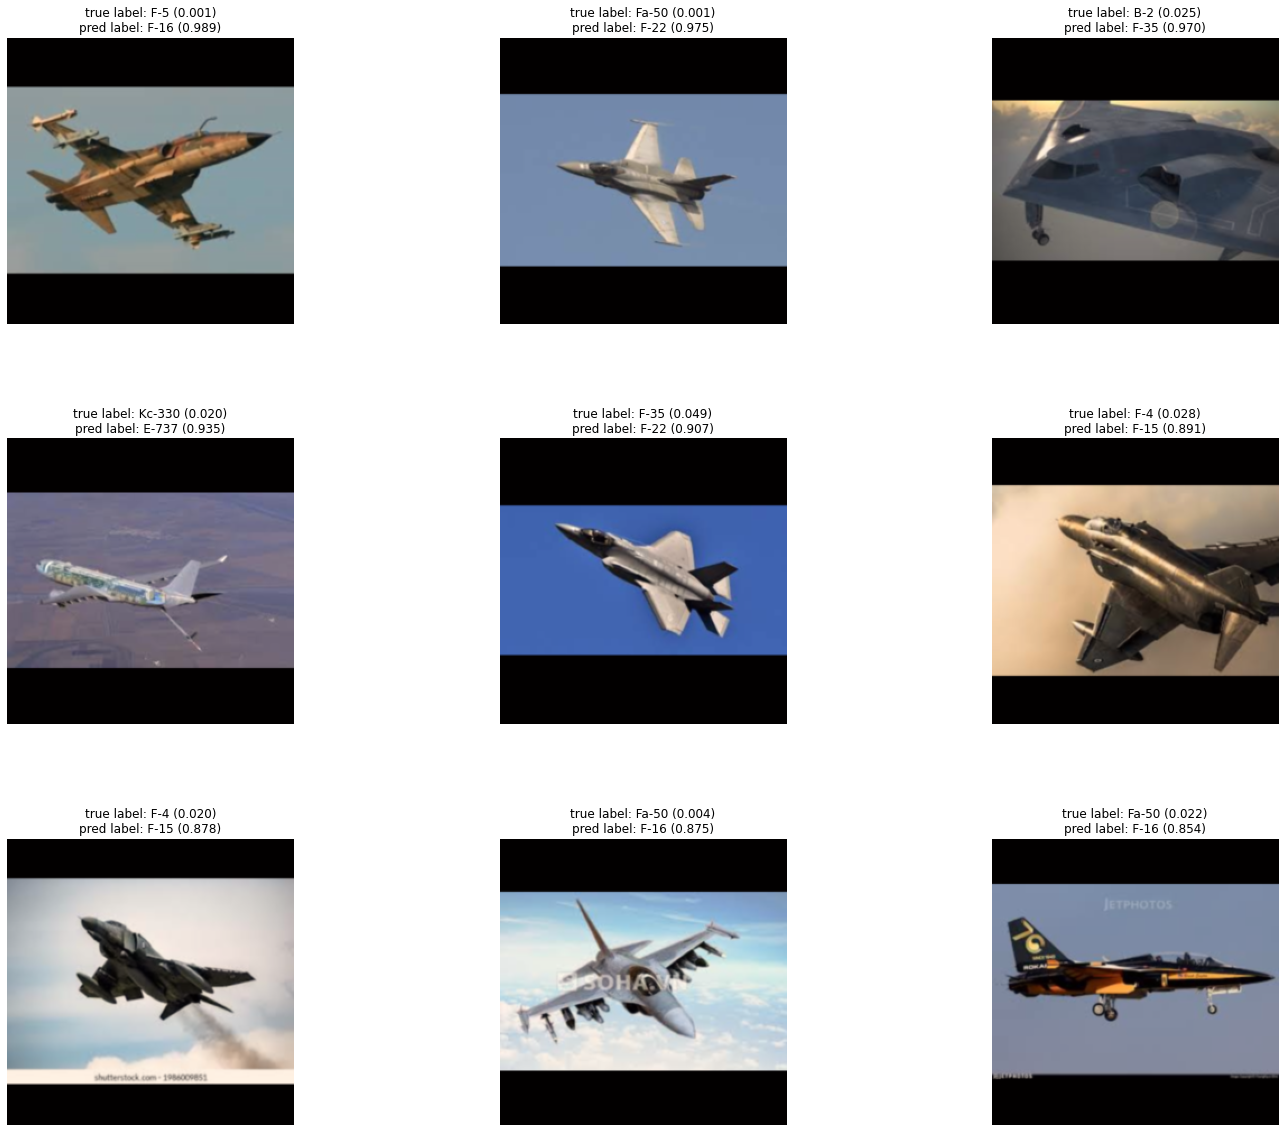

In [56]:
corrects = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

N_IMAGES = 14
plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

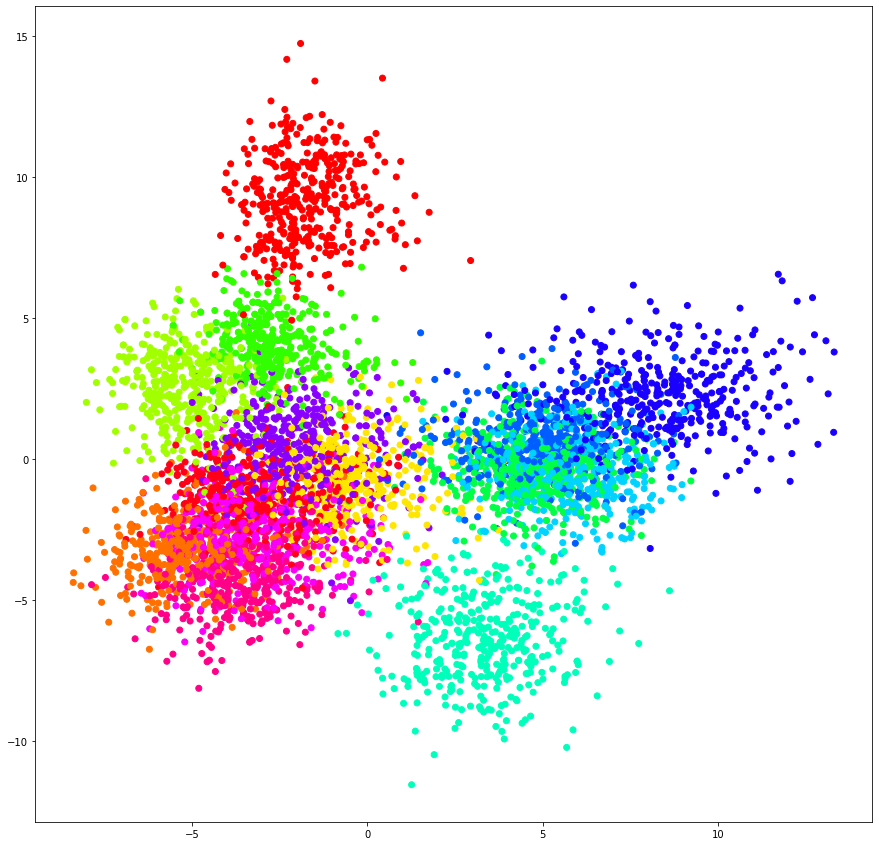

In [57]:
def get_representations(model, iterator):
    model.eval()
    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

outputs, labels = get_representations(model, train_iterator)

def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

def plot_representations(data, labels, classes, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'hsv')
    #handles, _ = scatter.legend_elements(num = None)
    #legend = plt.legend(handles = handles, labels = classes)

output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

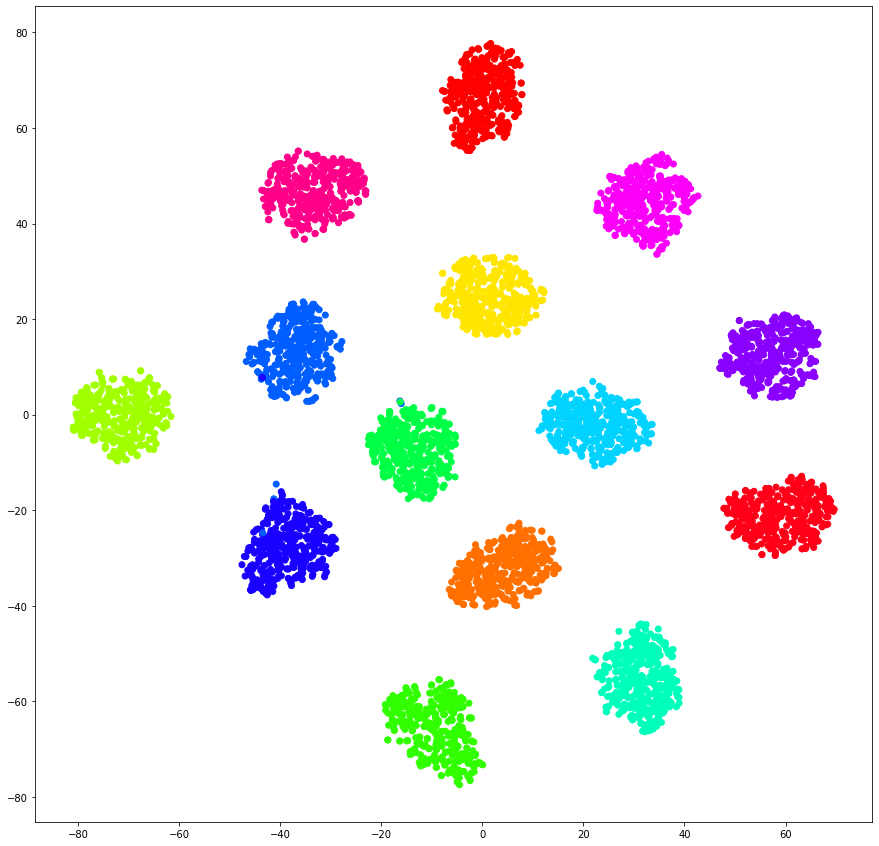

In [58]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels, classes)

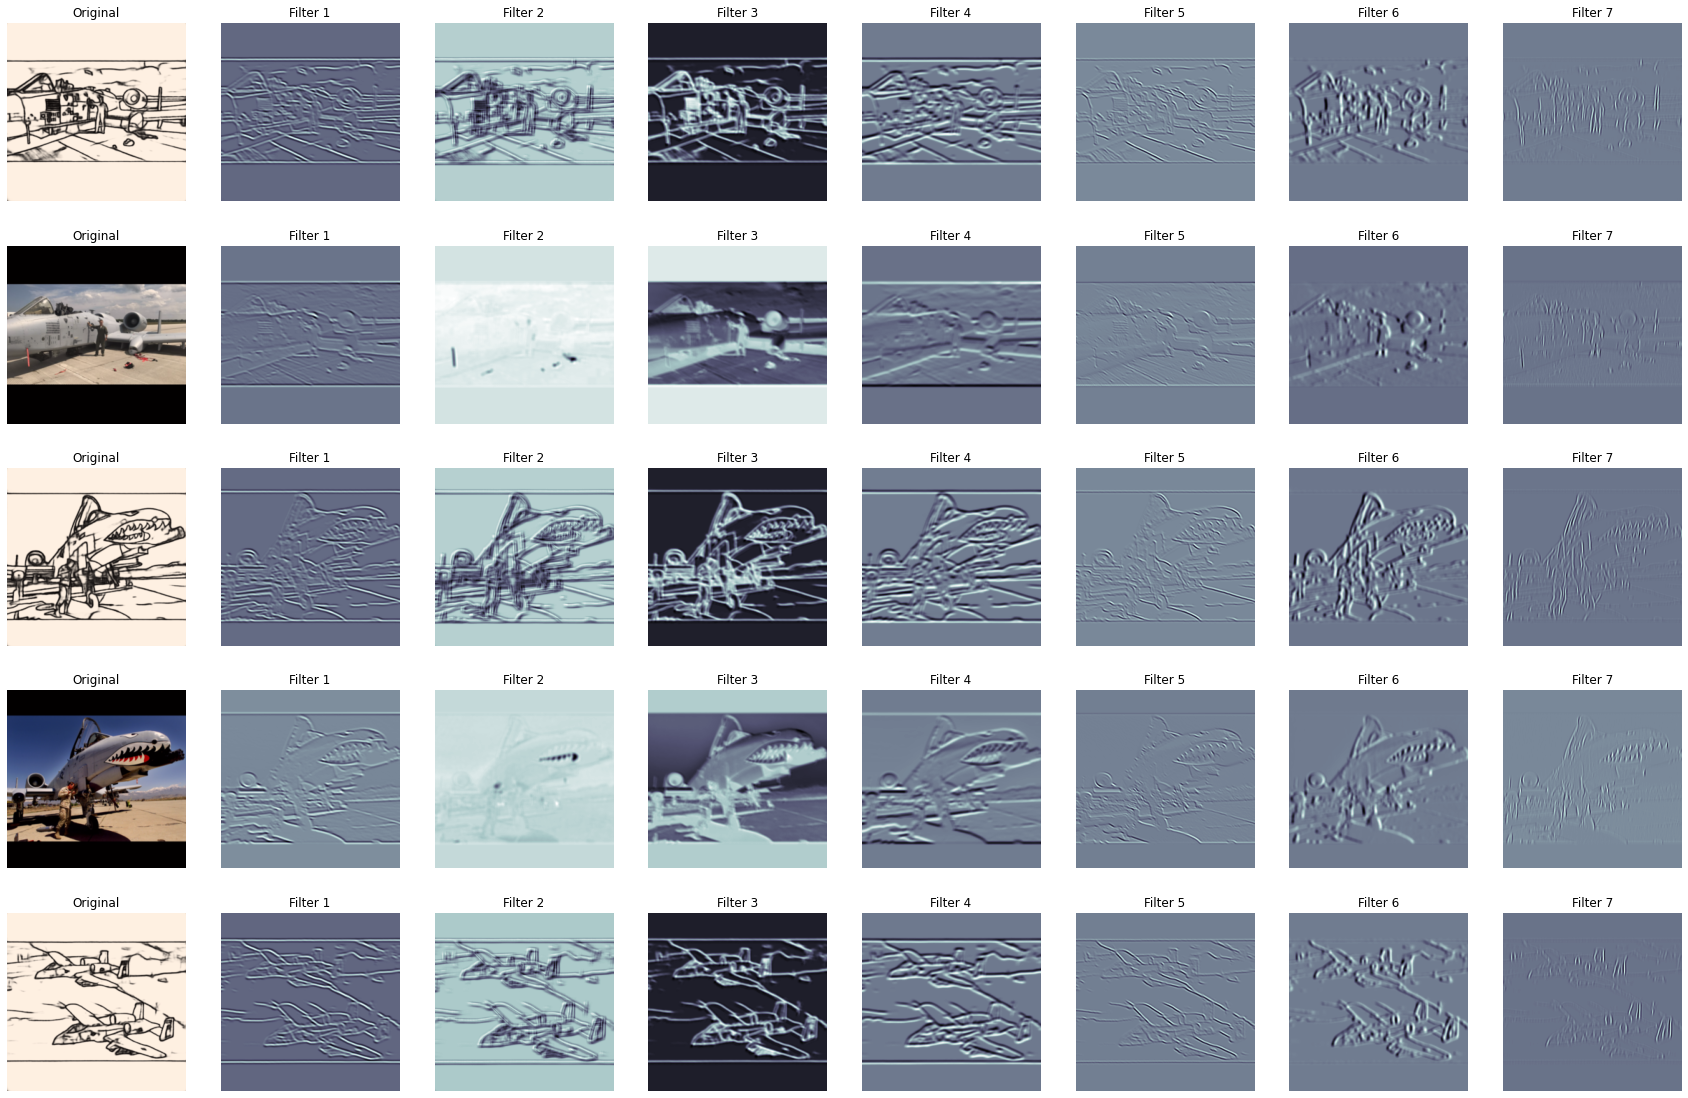

In [59]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters, N_FILTERS)

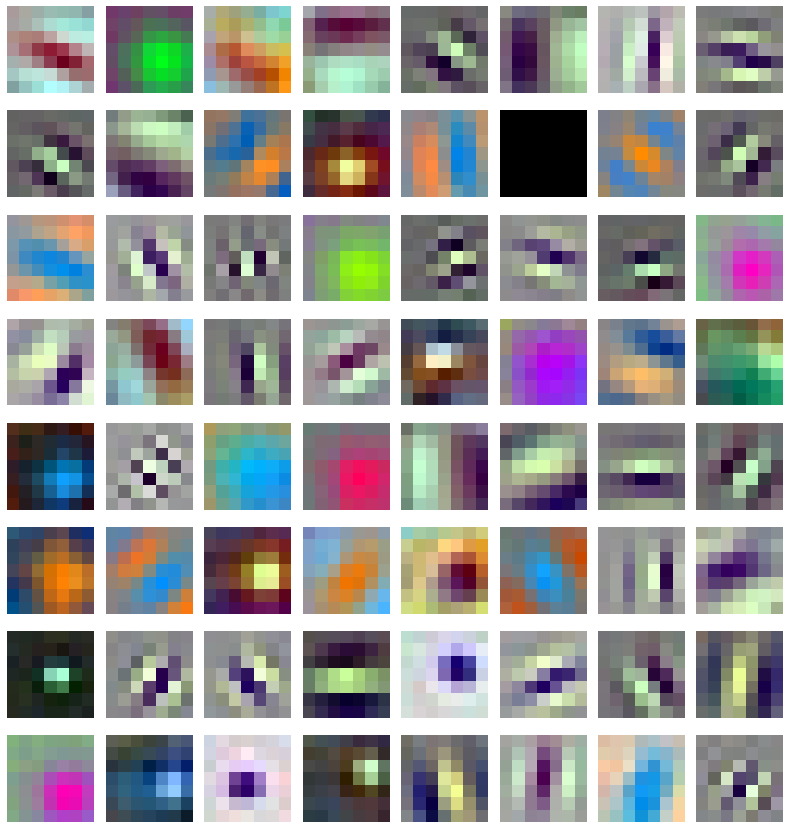

In [60]:
def plot_filters(filters, normalize = True):
    filters = filters.cpu()
    n_filters = filters.shape[0]
    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))
    fig = plt.figure(figsize = (30, 15))

    for i in range(rows*cols):
        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
        
    fig.subplots_adjust(wspace = -0.9)

plot_filters(filters)